# RNN Challenge
In this challenge, the goal is to train a classifier for sequences of genetic code.

**NOTE:** This notebook is based on: [NLP From Scratch: Classifying Names with a Character-Level RNN from Sean Robertson <https://github.com/spro/practical-pytorch>](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Load Data

In [2]:
with open('rnn-challenge-data.npz', 'rb') as f:
    X = np.load(f)
    data_x = X['data_x']
    data_y = X['data_y']
    val_x = X['val_x']
    val_y = X['val_y']
    test_x = X['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# VALIDATION DATA: INPUT (x) AND OUTPUT (y)
print(val_x.shape, val_x.dtype)
print(val_y.shape, val_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

(400,) <U400
(400,) int64
(100,) <U1200
(100,) int64
(250,) <U2000


## Helper Methods and Variables



In [3]:
def categoryFromOutput(output):
    """Interpret the output of the network, which we know to be a likelihood of each category. 
    We can use Tensor.topk to get the index of the greatest value:"""
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def genSeqToTensor(gen_seq):
    """Turn a sequence of genetic code into a <sequence_length x 1 x n_nucleobases> Tensor."""
    tensor = torch.zeros(len(gen_seq), 1, len(nucleobaseIndices))
    for idx, nucleobase in enumerate(gen_seq):
        tensor[idx][0][nucleobaseIndices[nucleobase]] = 1
    return tensor

nucleobaseIndices = {
    "A":0,
    "C":1,
    "G":2,
    "T":3
}

all_nucleobases = list(nucleobaseIndices.keys())
n_nucleobases = len(nucleobaseIndices)
all_categories = ["class 0","class 1","class 2","class 3","class 4"]
n_categories = len(all_categories)



## Custom Dataset

In [4]:
class GenSeqDataset(torch.utils.data.Dataset):
    def __init__(self, gen_sequences, labels):
        self.gen_sequences = gen_sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        gen_seq= self.gen_sequences[idx]
        gen_seq_tensor = genSeqToTensor( gen_seq)
        label_tensor = self.labels[idx]
        label = all_categories[label_tensor]
        label_tensor = torch.tensor([label_tensor], dtype=torch.long)
        return ( label,gen_seq, label_tensor,gen_seq_tensor)
data_ds = GenSeqDataset(data_x, data_y)
data_dl = torch.utils.data.DataLoader(data_ds, batch_size=1,
                        shuffle=True, num_workers=0)

## Define RNN
This RNN module (mostly copied from [the PyTorch for Torch users tutorial](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net) )
is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

![RNN architecture](https://i.imgur.com/Z2xbySO.png)

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inp, hidden):
        combined = torch.cat((inp, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_nucleobases, n_hidden, n_categories)

## (Optional) Load Trained Model

In [32]:
#rnn = RNN(n_nucleobases, n_hidden, n_categories)
#rnn.load_state_dict(torch.load("model-v1.pt"))
#rnn.eval()

## Training

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [10]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters())
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    optimizer.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    
    optimizer.step()
    return output, loss.item()

In [11]:
print_every = 400
plot_every = 200

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

epochs = 15
n_iters = epochs * len(data_ds)
i = 0
for e in range(epochs):
    for category, gen_seq, category_tensor, gen_seq_tensor in data_dl:
        i += 1
        category, gen_seq, category_tensor, gen_seq_tensor = category[0], gen_seq[0], category_tensor[0], gen_seq_tensor[0]
        output, loss = train(category_tensor, gen_seq_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if i % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, gen_seq, guess, correct))

        # Add current loss avg to list of losses
        if i % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

400 6% (0m 18s) 1.1769 GATCGTCACAGTGTCACAGTCTGAGTCAAGTCGTCAAGTCGATCGATCGATCGATCCTGACAGTGATCCAGTAGTCGATCGATCAGTCCAGTGTCAAGTCCAGTAGTCGATCAGTCAGTCGTCAGATCCTGACTGACTGACAGTGTCAAGTCGTCAAGTCCAGTGTCAAGTCGATCGTCACTGAAGTCGATCCAGTGATCCAGTGTCAAGTCCAGTGTCAGTCAAGTCCAGTGATCGATCCTGACAGTGATCAGTCAGTCCTGAGATCCAGTGATCCAGTAGTCAGTCCAGTGTCAAGTCCAGTAGTCGATCAGTCGATCAGTCCAGTGATCGATCCAGTCAGTGTCACAGTGATCAGTCAGTCGTCAGTCACAGTAGTCGTCACTGAGTCACTGAGATC / class 4 ✓
800 13% (0m 36s) 1.3481 GATCGATCCAGTCTAGGTCAGTCAGATCCTAGCTAGCTAGCTAGCTAGCTAGGATCCTGAGTCAGATCCTGACAGTGTCACTGAGTCAGATCGTCAGATCCTGACAGTCTGAGTCAGATCCTGACTGAGTCACTAGCTAGCTAGCTAGCTGAGATCCAGTCTAGCTAGCAGTCTAGCAGTCTAGCTAGGTCACTGACAGTCTGAGTCACAGTCTAGCTAGGTCACTAGGATCCTAGGATCGATCGTCACTGAGATCGTCAGATCCAGTCTAGGTCACAGTCTAGGTCACAGTCTAGCTAGCTGAGTCACTAGCTAGGATCCAGTGATCGATCGATCCTAGGTCACTGACAGTGATCCTGAGTCACTAGCTAGCTAGCTAGGATCCAGTCTAGCTAGGATC / class 4 ✗ (class 3)
1200 20% (0m 54s) 1.5965 CAGTGATCCAGTGTCAGTCAGTCACTGACTGACAGTCTGAGATCCTGAGTCAGATCGATCCTGAGTCACAGTGATCCAGTCTGACAGTGTCA

## (Optional) Save Model

In [27]:
# torch.save(rnn.state_dict(), "model-v2.pt")

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




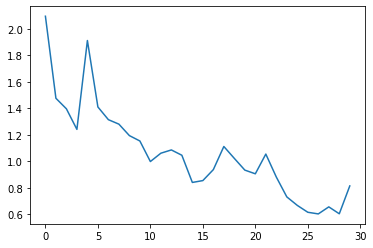

In [13]:
plt.figure()
plt.plot(all_losses)

## Evaluation

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual category (rows)
which category the network guesses (columns).

/home/center/.pyenv/versions/3.7.9/envs/dl-pt/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/center/.pyenv/versions/3.7.9/envs/dl-pt/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


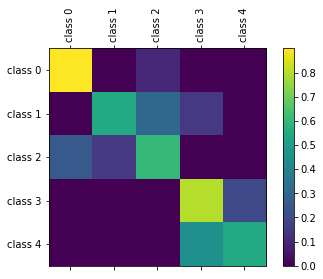

In [34]:
# Load validation dataset
val_ds = GenSeqDataset(val_x, val_y)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=1,
                        shuffle=True, num_workers=0)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = int(200 / len(val_ds))

# Just return an output given a line
def evaluate(line_tensor):
    """Same as train() without the backprop."""
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    for category, gen_seq, category_tensor, gen_seq_tensor in val_dl:
        category, gen_seq, category_tensor, gen_seq_tensor = category[0], gen_seq[0], category_tensor[0], gen_seq_tensor[0]
        output = evaluate(gen_seq_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Prediction

In [33]:
rnn = RNN(n_nucleobases, n_hidden, n_categories)
rnn.load_state_dict(torch.load("model-v1.pt"))
rnn.eval()

RNN(
  (i2h): Linear(in_features=132, out_features=128, bias=True)
  (i2o): Linear(in_features=132, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [45]:
def predict(input_line, n_predictions=3):
    with torch.no_grad():
        output = evaluate(genSeqToTensor(input_line))
        return categoryFromOutput(output)[1]

prediction = np.fromiter((predict(xi) for xi in test_x), int)
validation = np.fromiter((predict(xi) for xi in val_x), int)

In [46]:
(validation == val_y).sum() / len(val_y)

0.68

## Submission

In [44]:
# PREDICT prediction FROM test_x


# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 250

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (250, )
    assert loaded.dtype == int
    assert (loaded <= 4).all()
    assert (loaded >= 0).all()
validate_prediction_format()